<a href="https://colab.research.google.com/github/es-abdalrhman/PatternRecognition/blob/Main/lab1_PR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part1, Part2

In [1]:
from google.colab import files
import os
import zipfile

# Upload the zip file containing the images
uploaded = files.upload()

# Extract the uploaded zip file
for filename in uploaded.keys():
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('images')



Saving colab.zip to colab (1).zip


In [2]:
import os
import cv2
import pandas as pd
import numpy as np

base_dir = 'images/archive'

data = []
target = []

for subject_id in range(1, 41):
    subject_dir = os.path.join(base_dir, f's{subject_id}')

    # print(subject_dir)

    for img_id in range(1, 11):
        img_path = os.path.join(subject_dir, f'{img_id}.pgm')

        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # print(img)

        if img is not None:

            img_flat = img.flatten()

            data.append(img_flat)

            target.append(subject_id)

data = np.array(data)
target = np.array(target)

df = pd.DataFrame(data)

df['id'] = target

print("DataFrame shape:", df.shape)
print(df.info)

DataFrame shape: (400, 10305)
<bound method DataFrame.info of        0    1    2    3    4    5    6    7    8    9  ...  10295  10296  \
0     48   49   45   47   49   57   39   42   53   49  ...     44     40   
1     60   60   62   53   48   51   61   60   71   68  ...     35     28   
2     39   44   53   37   61   48   61   45   35   40  ...     30     36   
3     63   53   35   36   33   34   31   35   39   43  ...    169    166   
4     64   76   80   53   34   72   60   66   66   50  ...     28     34   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
395  123  121  126  122  127  127  123  124  123  127  ...     47     34   
396  129  127  133  124  131  129  130  129  127  132  ...     92     93   
397  125  119  124  125  124  121  123  125  123  123  ...     34     38   
398  119  120  120  118  120  121  121  116  120  121  ...     88     87   
399  125  124  124  126  123  125  127  123  124  124  ...     34     32   

     10297  10298  10299 

# Part3

In [3]:
# Separate odd and even rows
train_data = df.iloc[1::2]  # Odd rows for training
test_data = df.iloc[::2]  # Even rows for testing

train_labels = train_data['id']
test_labels = test_data['id']

train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

print("Training Data:")
print(train_data)
print("Training Labels:")
print(train_labels)
print("\nTesting Data:")
print(test_data)
print("Testing Labels:")
print(test_labels)

Training Data:
     0      1      2      3      4      5      6      7      8      9      \
1       60     60     62     53     48     51     61     60     71     68   
3       63     53     35     36     33     34     31     35     39     43   
5       43     50     41     58     78     83     67     48     44     46   
7       44     43     32     32     30     30     38     40     48     66   
9       34     34     33     32     38     40     39     49     54     57   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
391    127    131    128    129    127    128    127    128    128    129   
393    130    123    127    125    126    126    127    125    125    127   
395    123    121    126    122    127    127    123    124    123    127   
397    125    119    124    125    124    121    123    125    123    123   
399    125    124    124    126    123    125    127    123    124    124   

     ...  10294  10295  10296  10297  10298  10299  10300  1

# Part4

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

def PCA(X):

    X_mean = np.mean(X, axis=0)

    X_centered = X - X_mean

    cov_matrix = np.cov(X_centered, rowvar=False)

    cov_matrix = (cov_matrix + cov_matrix.T) / 2  # Enforce symmetry
    cov_matrix = np.around(cov_matrix, decimals=3)

    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    return eigenvalues, eigenvectors

def selectComponents_PCA(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)[::-1]
    total_variance = np.sum(eigenvalues)
    cumulative_variance = np.cumsum(eigenvalues[sorted_indices]) / total_variance
    k = np.argmax(cumulative_variance >= alpha) + 1
    U = eigenvectors[:, sorted_indices[:k]]


    # Normalize the eigenvectors
    U_normalized = U / np.linalg.norm(U, axis=0)

    return U_normalized

def project_data(X, U):
    return np.dot(X, U)


def classify(X_train, y_train, X_test, k=1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    return knn.predict(X_test)


eigenvalues, eigenvectors = PCA(train_data)

alphas = [0.8, 0.85, 0.9, 0.95]



for alpha in alphas:
    U = selectComponents_PCA(eigenvalues, eigenvectors)

    # Project data
    projected_train_pca = project_data(train_data, U)

    projected_test_pca = project_data(test_data, U)

    y_pred_pca = classify(projected_train_pca, train_labels, projected_test_pca)

    accuracy_pca = accuracy_score(test_labels, y_pred_pca)

    print(f"Accuracy for alpha={alpha}: {accuracy_pca}")


Accuracy for alpha=0.8: 0.93
Accuracy for alpha=0.85: 0.94
Accuracy for alpha=0.9: 0.945
Accuracy for alpha=0.95: 0.935


# **Part 5 LDA**

In [5]:
# the problem is the use of not separating data using class in the beginning
def LDA (data,labels):
    overallsamplemean =np.mean(data ,axis=0)
    # calculate Sb matrix instead of B to get the sperability between classes
    num_features = data.shape[1]
    classes = np.unique(labels)
    n_classes =len( classes)
    sb = np.zeros((num_features,num_features))
    for class_item in classes:
        class_items = data[labels == class_item]
        mean_class = np.mean(class_items,axis=0)
        n_items = class_items.shape[0]
        mean_diff = np.array(mean_class-overallsamplemean).reshape(-1,1)
        sb += n_items * np.dot(mean_diff,mean_diff.T)


    # Calculate S = s1 + s2 + .... + sn
    s = np.zeros((num_features, num_features))

    # Calculate Si for each sample in this position I made assumation that the data is separated each 5 groups together that's not always the case
    for class_item in classes:
        class_items = data[labels == class_item]
        mean_class  = np.mean(class_items,axis=0)
        n_items = class_items.shape[0]
        zi = np.array(class_items - mean_class)
        s += np.dot(zi.T, zi)



    eigenvalues , eigenvectors = np.linalg.eigh(np.linalg.pinv(s).dot(sb))
    print('eigenvectors are ',eigenvectors)
    return eigenvalues ,eigenvectors

def selectComponents_LDA(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)[::-1]
    U = eigenvectors[:, sorted_indices]
    # Normalize the eigenvectors
    U_normalized = U / np.linalg.norm(U, axis=0)

    return U_normalized[:,:39]

def project_data(X, U):
    return np.dot(X, U)


def classify(X_train, y_train, X_test, k=1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    return knn.predict(X_test)

train_data = df.iloc[1::2]  # Odd rows for training
test_data = df.iloc[::2]  # Even rows for testing

train_labels = train_data['id']
test_labels = test_data['id']

train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])
eigenvalues , eigenvectors =  LDA (train_data,train_labels)

# we need to drop column id before entering the loop


U = selectComponents_LDA(eigenvalues, eigenvectors)

# Project data
projected_train_lda = project_data(train_data, U)

projected_test_lda = project_data(test_data, U)

y_pred_lda = classify(projected_train_lda, train_labels, projected_test_lda)

accuracy_lda = accuracy_score(test_labels, y_pred_lda)

print(f"The LDA Accuracy {accuracy_lda}")


eigenvectors are  [[-5.92244074e-02  4.73370719e-01 -3.77627005e-02 ...  1.16719236e-02
  -4.02027138e-01 -2.70991902e-02]
 [-6.94702085e-02  5.90640837e-01 -4.92166566e-02 ...  8.03114019e-03
  -3.01650009e-01 -2.24282855e-02]
 [ 3.22849180e-04 -2.17999751e-01  3.10611831e-02 ...  2.51471710e-02
  -7.91259608e-01 -4.55836285e-02]
 ...
 [ 1.42294968e-03  4.97789378e-04  4.43650704e-03 ...  4.79259608e-03
   2.45968337e-04 -1.77832996e-03]
 [-7.52056797e-03 -5.02526908e-04  7.35607741e-03 ...  6.99794296e-03
  -9.30572348e-05  6.78007730e-03]
 [-2.27581355e-06  7.73645603e-04  1.12028717e-02 ...  1.17523243e-02
   4.38832790e-04 -9.52541551e-04]]
The LDA Accuracy 0.925


**Compare LDA with PCA**

from the results we see that the accuracy of PCA is higher by less values from LDA
As PCA give from 0.93 to 0.945 accuracy while LDA give 0.925





# **Part 6**

0.935
0.925
0.845
0.86
0.815
0.8
0.74
0.745
PCA_accuracies [0.935, 0.845, 0.815, 0.74]
LDA_accuracies [0.925, 0.86, 0.8, 0.745]


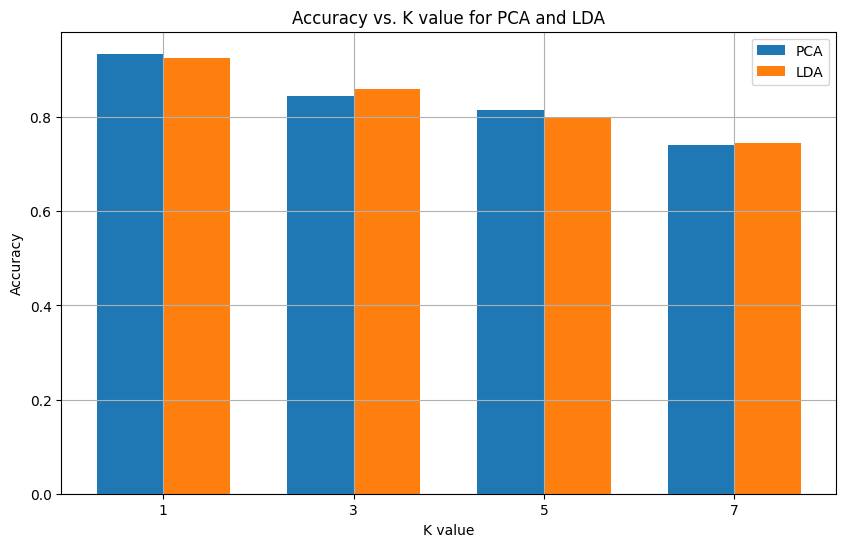

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt




def classify(X_train, y_train, X_test, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict classes for test data
    predicted_classes = knn.predict(X_test)

    # If there's only one class with maximum probability, return that class
    # Otherwise, use a secondary tie-breaking criterion (e.g., class with lowest index)
    unique_classes = np.unique(y_train)  # Unique classes present in the training data
    for i in range(len(predicted_classes)):
        if np.sum(predicted_classes[i] == unique_classes) != 1:
            # Multiple classes have the same maximum probability
            # Use secondary tie-breaking criterion (class with lowest index)
            predicted_classes[i] = np.min(np.where(predicted_classes[i] == unique_classes))

    return predicted_classes



# Define K values
k_values = [1, 3, 5, 7]

# Perform KNN classification and compute accuracy for each K value
PCA_accuracies = []
LDA_accuracies = []

# print(projected_train_pca)
# print(train_labels)
# print(projected_test_pca)
for k in k_values:
    # Call classify function for PCA
    y_pred_pca = classify(projected_train_pca, train_labels, projected_test_pca, k)
    accuracy_pca = accuracy_score(test_labels, y_pred_pca)
    print(accuracy_pca)
    PCA_accuracies.append(accuracy_pca)

    # Call classify function for LDA
    y_pred_lda = classify(projected_train_lda, train_labels, projected_test_lda, k)
    accuracy_lda = accuracy_score(test_labels, y_pred_lda)
    LDA_accuracies.append(accuracy_lda)
    print(accuracy_lda)

# Plotting as bar graph
plt.figure(figsize=(10, 6))

# Width of the bars
bar_width = 0.35

# Position of the bars on the x-axis
bar_positions_pca = np.arange(len(k_values))
bar_positions_lda = bar_positions_pca + bar_width
print('PCA_accuracies' , PCA_accuracies)
print('LDA_accuracies' , LDA_accuracies)
# Plotting bars for PCA
plt.bar(bar_positions_pca, PCA_accuracies, bar_width, label='PCA')

# Plotting bars for LDA
plt.bar(bar_positions_lda, LDA_accuracies, bar_width, label='LDA')

# Adding labels and titles
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K value for PCA and LDA')
plt.xticks(bar_positions_pca + bar_width / 2, k_values)
plt.legend()
plt.grid(True)
plt.show()

